## Physics-Informed Neural Network Tutorial Part 2: 2-D PDEs with Pytorch

### PINN for Helmholtz equation over a unit disk ##

The computational domain $\Omega$ is a $L$-length square, $L=4$, to which we remove a $R=1$ radius circle.
We consider the following Helmholtz equation with Dirichlet boundary conditions:
$$ -u_{xx} - u_{yy} - k_0^2u=f \quad \text{in} \quad \Omega $$
with a source term $f=k_0^2\sin(k_0 x)\sin(k_0 y)$, the wave number $k_0=2\pi n$ with $n=1$. We set the exact solution as being:
$$u(x,y) = \sin(k_0x)\sin(k_0y)$$

### 1. Define The Problem

In [1]:
import torch
import numpy as np
import math

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

k0 = 2.0*np.pi

def f_source(x):
    sr_trm = k0**2*np.sin(k0*x[:,0])*np.sin(k0*x[:,1])
    # sr_trm = sr_trm.astype(np.float32)
    return sr_trm

def u_ext(x):
    u_true = np.sin(k0*x[:,0])*np.sin(k0*x[:,1])
    # u_true = u_true.astype(np.float32)
    return u_true

def normal_vector(x):
    arr_cos = []
    arr_sin = []
    for i in range(len(x)):
        theta = math.atan2(x[i,1], x[i,0])
        arr_cos.append(np.cos(theta))
        #np.append(arr_cos, [np.cos(theta)])
        arr_sin.append(np.sin(theta))
        #np.append(arr_sin, [np.sin(theta)])
    return np.array([arr_cos, arr_sin], dtype=float).T

def Neumann_bc(x):
    arr_1=[]
    for i in range(50):
        arr_1.append(k0*np.cos(k0*x[i,0])*np.sin(k0*x[i,1]))
    arr_2=[]
    for i in range(50):
        arr_2.append(k0*np.sin(k0*x[i,0])*np.cos(k0*x[i,1]))
    
    #del_u = np.array([[k0*np.cos(k0*x[:,0])*np.sin(k0*x[:,1])], [k0*np.sin(k0*x[:,0])*np.cos(k0*x[:,1])]], dtype=float).T
    
    del_u=[arr_1,arr_2]
    return np.dot(del_u, normal_vector(x))

#ef = torch.tensor(0.02, dtype=torch.float64).to(device)
#eb = torch.tensor(0.02, dtype=torch.float64).to(device)

ModuleNotFoundError: No module named 'torch'

### 2. Define Geometric Configuration using NURBS Surface in 2D
A surface is built up from two BSplineBasis and accompanied by a tensor *net* of controlpoints. Using *n* basis functions of order *p* in the *u*-direction and *m* basis functions of order *q* in the *v*-direction, we may evaluate surfaces by the following expression
$$ x(u,v) = \sum_{i=1}^n\sum_{j=1}^m B_{i,p}(u)B_{j,q}(v) x_{ij}$$

[(-1.0, 1.0), (-1.0, 1.0)]
(101, 101, 2)
(3, 3, 2)
(2, 2, 2)


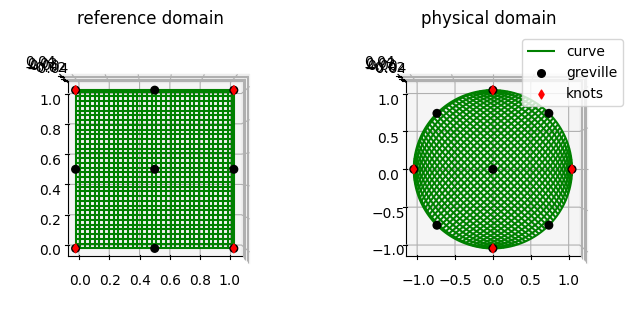

In [ ]:
import splipy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

basis_x = sp.BSplineBasis(3, [0,0,0,1,1,1])   # 1d quadratic basis
basis_y = sp.BSplineBasis(3, [0,0,0,1,1,1])   # 1d quadratic basis
control_net = [[1,0,1], [1/np.sqrt(2),1/np.sqrt(2),1/(np.sqrt(2))], [0,1,1],
               [1/np.sqrt(2),-1/np.sqrt(2),1/np.sqrt(2)], [0,0,1], [-1/np.sqrt(2),1/np.sqrt(2),1/np.sqrt(2)],
               [0,-1,1], [-1/np.sqrt(2),-1/np.sqrt(2),1/np.sqrt(2)], [-1,0,1]]
surface = sp.Surface(basis_x, basis_y, control_net, rational=True)
print(surface.bounding_box())

grv_x,grv_y = basis_x.greville(),basis_y.greville()

u = np.linspace(0,1,101) # 21 uniformly spaced evaluation points in u (domain (0,1))
v = np.linspace(0,1,101) # 21 uniformly spaced evaluation points in u (domain (0,1))
x = surface(u,v)
gx= surface(grv_x, grv_y)
kx= surface(surface.knots()[0],surface.knots()[1])
print(x.shape)
print(gx.shape)
print(kx.shape)
zz= np.ones((len(grv_x),len(grv_y)))
z = np.zeros((len(u),len(v)))

uv, vv = np.meshgrid(u,v)
zv = np.zeros((len(u),len(v)))
ug, vg = np.meshgrid(grv_x,grv_y)
uk, vk = np.meshgrid(basis_x.knot_spans(),basis_y.knot_spans())

fig, ax = plt.subplots(1,2,subplot_kw={"projection": "3d"},figsize=(8,12))

ax[0].plot_wireframe(uv, vv, zv,colors='g')
ax[0].scatter(ug,vg,c='k',s=30)
ax[0].scatter(uk,vk,c='r',s=20,marker='d')
#ax[0].legend(('reference','greville','knots'))
ax[0].set_title('reference domain')
ax[0].view_init(90, -90)

#ax[1].plot_wireframe(surface.controlpoints[:,:,0], surface.controlpoints[:,:,1],zz,linestyle='-.')   # plot as wireframe
ax[1].plot_wireframe(x[:,:,0], x[:,:,1], z,colors='g')   # plot as wireframe
ax[1].scatter(gx[:,:,0],gx[:,:,1],c='k',s=30)
ax[1].scatter(kx[:,:,0],kx[:,:,1],c='r',s=20,marker='d')
ax[1].set_title('physical domain')
ax[1].legend(('curve','greville','knots'))
#ax[1].legend(('control pts','curve','greville','knots'))
ax[1].view_init(90, -90)
plt.show()

### 3. Generate A Sample Data Set (Randomly selected Collocation Points)

(9801, 2)
(400, 2)


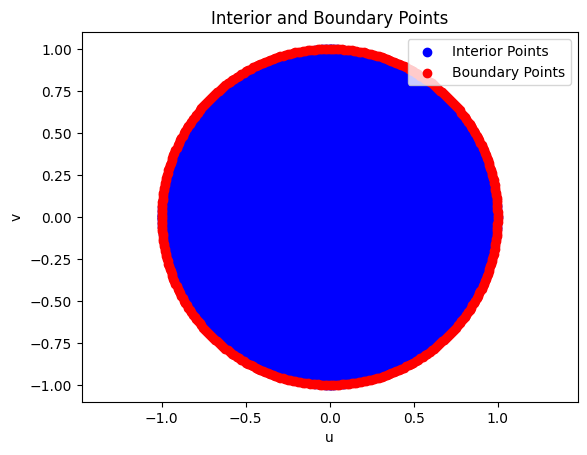

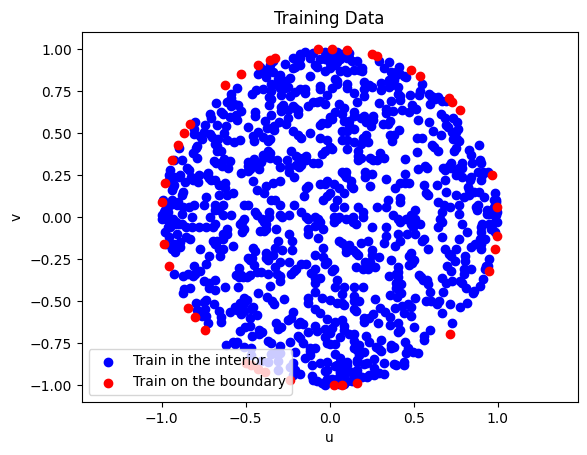

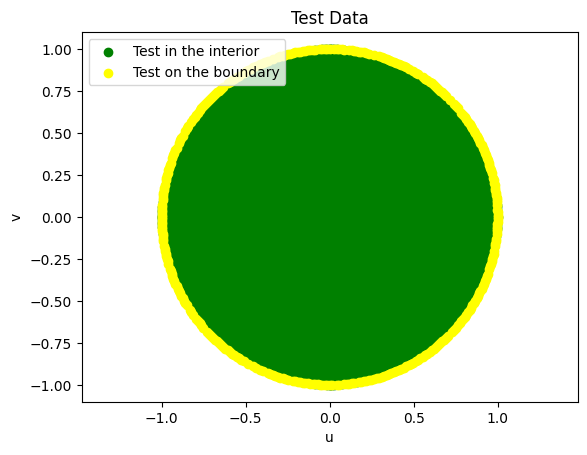

In [ ]:
# Reshape x into a length(u)*length(v) by 2 matrix
x_rspd = x.reshape((-1, 2))
#print(x_reshaped)

# Split x_reshaped into the array containing interior points and the array containing boundary points

# Calculate the Euclidean distance from the origin for each point
distances = np.sqrt(x_rspd[:, 0]**2 + x_rspd[:, 1]**2)

# Define a threshold radius for the boundary
radius = 1.0

# Create a boolean mask to identify the points on the boundary
boundary_mask = np.isclose(distances, radius)

# Split the matrix into interior points and boundary points
intrr_pts = x_rspd[~boundary_mask]
bd_pts = x_rspd[boundary_mask]

print(intrr_pts.shape)
print(bd_pts.shape)

# Plot interior points
plt.scatter(intrr_pts[:, 0], intrr_pts[:, 1], c='blue', label='Interior Points')

# Plot boundary points
plt.scatter(bd_pts[:, 0], bd_pts[:, 1], c='red', label='Boundary Points')

# Set plot labels and title
plt.xlabel('u')
plt.ylabel('v')
plt.title('Interior and Boundary Points')
# Add legend
plt.legend()
# Set the aspect ratio to be equal
plt.axis('equal')
# Show the plot
plt.show()

# Randomly choose sample points from interior and boundary points for each

# Set the rate of the sample data
smpl_rate = 0.01
# Figure out the number of sample points to be selected from interior and boundary points for each
num_smpl_intrr = np.ceil(smpl_rate*intrr_pts.shape[0])
num_smpl_bd = np.ceil(smpl_rate*bd_pts.shape[0])

# Change the data type to integer
num_smpl_intrr = num_smpl_intrr.astype('int')
num_smpl_bd    = num_smpl_bd.astype('int')
num_smpl_ttl   = num_smpl_intrr + num_smpl_bd


# Get the number of points in the interior_points and boundary_points for each
num_pts_intrr = intrr_pts.shape[0]
num_pts_bd = bd_pts.shape[0]

# Randomly chosen indices
rnd_ndx_intrr = np.random.choice(num_pts_intrr, size=num_smpl_intrr, replace=False)
rnd_ndx_bd = np.random.choice(num_pts_bd, size=num_smpl_bd, replace=False)

# Select the corresponding rows (points) from the interior points and boundary points for each (Sample the training data)
smpl_intrr = intrr_pts[rnd_ndx_intrr, :]
smpl_bd    = bd_pts[rnd_ndx_bd, :]

smpl_ttl = np.vstack((smpl_intrr, smpl_bd))

# Find the indices of the points that were not selected
rnd_ndx_tst_intrr = np.setdiff1d(np.arange(num_pts_intrr), rnd_ndx_intrr)
rnd_ndx_tst_bd    = np.setdiff1d(np.arange(num_pts_bd), rnd_ndx_bd)

# Select the corresponding rows (points) from the interior and boundary arrays for the non-selected points
tst_intrr = intrr_pts[rnd_ndx_tst_intrr, :]
tst_bd    = bd_pts[rnd_ndx_tst_bd, :]

tst_ttl = np.vstack((tst_intrr, tst_bd))

# Print the randomly chosen points
# print(smpl_intrr.shape, smpl_bd.shape)
# print(smpl_intrr, smpl_bd)

# Plot interior sample training points
plt.scatter(smpl_intrr[:, 0], smpl_intrr[:, 1], c='blue', label='Train in the interior')

# Plot boundary sample training points
plt.scatter(smpl_bd[:, 0], smpl_bd[:, 1], c='red', label='Train on the boundary')

# Set plot labels and title
plt.xlabel('u')
plt.ylabel('v')
plt.title('Training Data')
# Add legend
plt.legend()
# Set the aspect ratio to be equal
plt.axis('equal')
# Show the plot
plt.show()

# Plot interior test points
plt.scatter(tst_intrr[:, 0], tst_intrr[:, 1], c='green', label='Test in the interior')

# Plot boundary test points
plt.scatter(tst_bd[:, 0], tst_bd[:, 1], c='yellow', label='Test on the boundary')

# Set plot labels and title
plt.xlabel('u')
plt.ylabel('v')
plt.title('Test Data')
# Add legend
plt.legend()
# Set the aspect ratio to be equal
plt.axis('equal')
# Show the plot
plt.show()

### 4. Design A Neural Network

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import math

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.hidden_layer1 = nn.Linear(2,24)
        self.hidden_layer2 = nn.Linear(24,24)
        self.hidden_layer3 = nn.Linear(24,24)
        self.output_layer = nn.Linear(24,1)

    def forward(self, x):
        layer1_out = torch.sin(self.hidden_layer1(x))
        layer2_out = torch.sin(self.hidden_layer2(layer1_out))
        layer3_out = torch.sin(self.hidden_layer3(layer2_out))
        output = self.output_layer(layer3_out) ## For regression, no activation is used in output layer
        return output

NN = NeuralNetwork()
NN = NN.to(device)
print(NN)

Using cpu device
NeuralNetwork(
  (hidden_layer1): Linear(in_features=2, out_features=64, bias=True)
  (hidden_layer2): Linear(in_features=64, out_features=64, bias=True)
  (hidden_layer3): Linear(in_features=64, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


### 5. Construct A Loss Function of The PDE
''torch.autograd.grad(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False, only_inputs=True, allow_unused=False)''

* outputs: A tensor or a sequence of tensors representing the values you want to compute gradients with respect to. These are typically the loss or objective values.
* inputs: A tensor or a sequence of tensors representing the tensors you want to differentiate with respect to. These are typically the model parameters or variables.
* grad_outputs (optional): A tensor or a sequence of tensors specifying the initial gradients for the outputs. This argument is useful when you want to compute higher-order gradients.
* retain_graph (optional): A Boolean value indicating whether to retain the computation graph for further differentiation steps. If you need to call grad multiple times, you can set this to True.
* create_graph (optional): A Boolean value indicating whether to create a graph of the derivative computation. This is necessary when you want to compute gradients of gradients (second-order or higher derivatives).
* only_inputs (optional): A Boolean value indicating whether to return gradients only for the inputs. By default, it's set to True. If set to False, the function will return gradients for all tensors passed in inputs.
* allow_unused (optional): A Boolean value indicating whether to allow some of the inputs to be unused. If set to True, the function will not raise an error if some tensors in inputs are not used to compute the outputs.
The output of torch.autograd.grad is a tuple of gradients, where each element corresponds to the gradient of the respective input tensor(s). The gradients are computed using the chain rule of calculus and have the same shape as the inputs.


In [ ]:
import torch.nn.functional as F

mse = torch.nn.MSELoss() # Mean squared error

def get_loss_total(model, train_total, train_intrr, train_bd_D):
    trc_ttl   = Variable(torch.from_numpy(train_total).float(), requires_grad=True).to(device)
    trc_intrr = Variable(torch.from_numpy(train_intrr).float(), requires_grad=True).to(device)
    trc_bd_D  = Variable(torch.from_numpy(train_bd_D).float(), requires_grad=False).to(device)

    num_trc_ttl = trc_ttl.shape[0]
    num_trc_intrr = trc_intrr.shape[0]
    num_trc_bd_D  = trc_bd_D.shape[0]
    # num_trc_bd_N  = trc_bd_N.shape[0]
    # print(num_trc_ttl,num_trc_intrr,num_trc_bd_D)

    # Build the loss based on boundary conditions
    u_app_bd_D = model(trc_bd_D) # Find the universal approximator using the boundary conditions
    u_bd_D = u_ext(train_bd_D)  # Evaluate the exact solution on the boundary conditions
    u_bd_D = u_bd_D.reshape(u_bd_D.shape[0],1) # Reshape 'u_bd_D' to match the shape with 'u_app_bd_D'
    trc_u_bd_D = Variable(torch.from_numpy(u_bd_D).float(), requires_grad=False).to(device) # Convert the data format to tensor in pytorch
    trc_u_bd_D = trc_u_bd_D.view(trc_u_bd_D.shape[0],1) # Reshape 'trc_u_bd_D' to match with 'u_app_bd_D' (just in case)
    loss_bd_D = mse(u_app_bd_D, trc_u_bd_D) # Compute the mean squared error
    
    # Build the loss based on PDE
    u_app = model(trc_intrr) # Find the universla approximator using the interior train sample points
    # Compute the Jacobian matrix
    grad = torch.autograd.grad(u_app.sum(), trc_intrr, retain_graph=True, create_graph=True)[0].to(device)
    # dudx = grad[0:(num_trc_intrr), 0].to(device)
    # dudy = grad[0:(num_trc_intrr), 1].to(device)
    # Compute the Hessian matrix
    hessian = torch.autograd.grad(grad.sum(), trc_intrr, create_graph=True)[0].to(device)
    d2udx2 = hessian[:, 0].to(device)
    d2udy2 = hessian[:, 1].to(device)
    # Reshape
    d2udx2 = d2udx2.view(d2udx2.shape[0],1)
    d2udy2 = d2udy2.view(d2udy2.shape[0],1)
    # Approximation of the LHS of the governing equation (PDE) by the universal approximator
    pde_lhs = -d2udx2 - d2udy2 - k0**2*u_app
    # Evaluation of the source term (RHS of the governing equation) at the interior train sample points
    pde_rhs = f_source(train_intrr)
    # Reshape
    pde_rhs = pde_rhs.reshape(pde_rhs.shape[0],1)
    # Convert data format to tensor
    trc_pde_rhs = Variable(torch.from_numpy(pde_rhs).float(), requires_grad=True).to(device)
    # Reshape (just in case)
    trc_pde_rhs = trc_pde_rhs.view(trc_pde_rhs.shape[0],1)
    # Compute the PDE loss
    loss_pde = mse(pde_lhs, trc_pde_rhs)
    # Total loss
    loss_ttl = 0.1*loss_pde + 10.0*loss_bd_D

    return loss_ttl

    

### 6. Compute the optimal weights in Neural Network

In [ ]:


# Define the optimizer

################################################################
# Adams Optimizer

# Set the learning rate and number of epochs
# learning_rate = 0.01
# num_epochs = 5000

# optimizer = torch.optim.Adam(NN.parameters())

# # Train the model
# for epoch in range(num_epochs):
#     optimizer.zero_grad()
#     objective = get_loss_total(NN, smpl_ttl, smpl_intrr, smpl_bd)
#     objective.backward()
#     optimizer.step()
        
#     if (epoch + 1) % 1000 == 0:
#         print(f'Epoch: {epoch+1}, Loss: {objective.item():.4f}')
################################################################

################################################################
# Create closure function for LBFGS optimizer
def closure():
    optimizer.zero_grad()
    # Add regularization term if desired
    #regularization = 0.001 * sum(p.norm(2) for p in model.parameters())
    objective = get_loss_total(NN, smpl_ttl, smpl_intrr, smpl_bd)
    objective.backward()
    return objective

# L-BFGS optimizer
from torch.optim import LBFGS
optimizer = LBFGS(NN.parameters(), lr=0.2, max_iter=20, line_search_fn='strong_wolfe')

# Set the learning rate and number of epochs
num_epochs = 1000

# Train the model
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss_val = optimizer.step(closure)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch: {epoch+1}, Loss: {loss_val.item():.16f}')
################################################################

Epoch: 100, Loss: 0.0325991697609425
Epoch: 200, Loss: 0.0033669818658382
Epoch: 300, Loss: 0.0011355475289747
Epoch: 400, Loss: 0.0011011080350727
Epoch: 500, Loss: 0.0011011080350727
Epoch: 600, Loss: 0.0011011080350727
Epoch: 700, Loss: 0.0011011080350727
Epoch: 800, Loss: 0.0011011080350727
Epoch: 900, Loss: 0.0011011080350727
Epoch: 1000, Loss: 0.0011011080350727


### 7. Test the model

In [ ]:
%matplotlib

import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator
from mpl_toolkits.mplot3d import Axes3D

# Test the model
NN.eval()
with torch.no_grad():
    predicted = NN(torch.tensor(tst_ttl, dtype=torch.float32).to(device)).cpu()

# print(predicted.shape)    

u_true = u_ext(tst_ttl)
# Transform true and predicted values in dataframes
data_ext = pd.DataFrame({'x': tst_ttl[:,0], 'y': tst_ttl[:,1], 'z': u_true})
data_f_source = pd.DataFrame({'x': tst_ttl[:,0], 'y': tst_ttl[:,1], 'z': f_source(tst_ttl)})
data_prdtd = pd.DataFrame({'x': tst_ttl[:,0], 'y': tst_ttl[:,1], 'z': predicted[:,0]})
data_err = pd.DataFrame({'x': tst_ttl[:,0], 'y': tst_ttl[:,1], 'z': np.abs(predicted[:,0]-u_true)})

# Graph the plot of the true solution
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_trisurf(data_ext.x, data_ext.y, data_ext.z, cmap=plt.cm.Spectral, linewidth=0.2)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('u(x,y)')
plt.show()

# # Loop to keep the plot open until closed
# while plt.fignum_exists(fig.number):
#     plt.pause(0.1)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(tst_ttl[:, 0], tst_ttl[:, 1], u_ext(torch.tensor(tst_ttl, dtype=torch.float32)), label='Actual')
# ax.scatter(tst_ttl[:, 0], tst_ttl[:, 1], predicted, label='Predicted')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('u(x,y)')
# plt.legend()

Using matplotlib backend: <object object at 0x1416532a0>


In [ ]:
# Graph the plot of the approximate solution
fig = plt.figure()
ax3 = fig.add_subplot(111, projection='3d')
ax3.plot_trisurf(data_prdtd.x, data_prdtd.y, data_prdtd.z, cmap=plt.cm.Spectral, linewidth=0.2)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('u^NN(x,y)')
# plt.show()

Text(0.5, 0, 'u^NN(x,y)')

In [ ]:
# Graph the plot of the point-wise error
fig = plt.figure()
ax3 = fig.add_subplot(111, projection='3d')
ax3.plot_trisurf(data_err.x, data_err.y, data_err.z, cmap=plt.cm.Spectral, linewidth=0.2)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('|u-u^NN|')
# plt.show()



Text(0.5, 0, '|u-u^NN|')

In [ ]:
# Enable mouse interaction for adjusting view angle
plt.ion()
ax3.mouse_init()

# Enter interactive mode
plt.show(block=False)

# Loop to keep the plot open until closed
while plt.fignum_exists(fig.number):
    plt.pause(0.1)

## Helmholtz equation over a 2D square domain with a hole ##

The computational domain $\Omega$ is a $L$-length square, $L=4$, to which we reove a $R=1$ radius circle.
We consider the following Helmholtz equation:
$$ -u_{xx} - u_{yy} - k_0^2u=f \quad \text{in} \quad \Omega $$
with a source term $f=k_0^2\sin(k_0 x)\sin(k_0 y)$, the wave number $k_0=2\pi n$ with $n=1$. We set the exact solution as being:
$$u(x,y) = \sin(k_0x)\sin(k_0y)$$

Let $\Gamma_{inner}$ and $\Gamma_{outer}$ be the inner and outer boundaries of the computational domain $\Omega$. We impose Dirichlet boundary conditions on $\Gamma_{outer}$, and Neumann boundary conditions on $\Gamma_{inner} as follows:
$$ u(x,y) = \sin(k_0x)\sin(k_0y), \quad (x,y)\in\Gamma_{outer}, $$
$$ \nabla u(x,y) \cdot \mathbf{n} = \langle k_0\cos(k_0x)\sin(k_0y), k_0\sin(k_0x)\cos(k_0y)\rangle \cdot \langle \cos(\theta), \sin(\theta)  \rangle, \quad (x,y)\in\Gamma_{inner}, $$
where $\mathbf{n}$ is the normal exterior vector.

<div>
<center><img src="Helmholtz_domain1.png" alt="Helmholtz domain" style="width: 400px;"/></center>
</div>

<div>
<center><img src="Helmholtz_domain2.png" alt="Partitions of Helmholtz domain" style="width: 400px;"/></center>
</div>

Reference:
"DeepXDE: Helmholtz equation over a 2D square domain with a hole"

## Poisson equation
Consider the Laplace equation
$$ \Delta u = f(x,y) \quad \text{in} \ \Omega=[-1,1]\times[-1,1] $$
where
* $u = (x^2-1)(y^2-1) + \sin (x) \cos(y)$,
* $f(x,y) = -2\left[ (x^2-1) + (y^2-1)\right] + 2\sin(x)\cos(y)$

## Viscous Burgers' equation
Consider the nonlinear convection-diffusion equation

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} = \lambda\frac{\partial^2 u}{\partial x^2}, \quad v>0$$

which is known as Burgers' equation. 
The loss function includes a supervised loss of data measurements of $u$ from the initial and boundary conditions and an unsupervised loss of PDE:

$$\mathcal{L} = w_{data}\mathcal{L}_{data} + w_{PDE}\mathcal{L}_{PDE},$$

$$ u(x,0) = u_0(x), $$

$$ u(x,t) = g(x,t) \quad in \ \partial\Omega,$$

where

$$\mathcal{L}_{data} = \frac{1}{N_{data}}\left[\sum_{i=1}^{N_{dataIC}}\left\{NN(x_i,0;\theta) - u_0(x_i)\right\}^2 + \sum_{i=1}^{N_{dataBC}}\left\{NN(x_i,t_i;\theta) - g(x_i,t_i)\right\}^2\right],$$

$$\mathcal{L}_{PDE} = \frac{1}{N_{PDE}}\sum_{j=1}^{N_{PDE}}\left[\frac{\partial NN(x_j,t_j;\theta)}{\partial t} + NN(x_j,t_j;\theta)\frac{\partial NN(x_j,t_j;\theta)}{\partial x} - \lambda\frac{\partial^2 NN(x_j,t_j;\theta)}{\partial x^2}\right]^2\vert_{(x_j,t_j)},$$

* $\{(x_i,t_i)\}$ is a set of points sampled at the initial and boundary locations,

* $\{(x_j,t_j)\}$ is a set of points sampled in the entire domain,

* $N_{data} = N_{dataIC} + N_{dataBC}$,

* $w_{data}$ and $w_{PDE}$ are the weights used to balance the interplay between $\mathcal{L}_{data}$ and $\mathcal{L}_{PDE}$ (These weights can be user-defined or tuned automatically, and play an important role in improving the trainability of PINNs.),

* $NN(x,t;\theta)$ is an universal function approximator.